# Unicycle Car Model

In [1]:
using NeuralNetworkAnalysis
using NeuralNetworkAnalysis: UniformAdditivePostprocessing, SingleEntryVector

This benchmark is that of a unicycle model of a car [^1] taken from Benchmark
10 of the Sherlock tool. It models the dynamics of a car involving 4
variables, specifically the $x$ and $y$ coordinates on a 2 dimensional
plane, as well as velocity magnitude (speed) and steering angle.

## Model

The model is a four-dimensional system given by the following equations:

$$
\left\{ \begin{array}{lcl}
\dot{x}_1 &=& x_4 \cos(x_3) \\
\dot{x}_2 &=& x_4 \sin(x_3) \\
\dot{x}_3 &=& u_2 \\
\dot{x}_4 &=& u_1 + w
\end{array} \right.
$$
where $w$ is a bounded error in the range $[−1e−4, 1e−4]$. A neural
network controller was trained for this system. The trained network has 1
hidden layer with 500 neurons. Note that the output of the neural network
$f(x)$ needs to be normalized in order to obtain $(u_1, u_2)$, namely
$u_i = f(x)_i − 20$. The sampling time for this controller is 0.2s.

We model the error $w$ as a nondeterministically assigned constant.

In [2]:
@taylorize function unicycle!(dx, x, p, t)
    x₁, x₂, x₃, x₄, w, u₁, u₂ = x

    dx[1] = x₄ * cos(x₃)
    dx[2] = x₄ * sin(x₃)
    dx[3] = u₂
    dx[4] = u₁ + w
    dx[5] = zero(x[5])
    dx[6] = zero(x[6])
    dx[7] = zero(x[7])
    return dx
end

controller = read_nnet_mat(@modelpath("Sherlock-Benchmark-10-Unicycle",
                                      "controllerB_nnv.mat");
                           act_key="act_fcns");

## Specification

The verification problem here is that of reachability. For an initial set of,
$x_1 ∈ [9.5,9.55], x_2 ∈ [−4.5,−4.45], x_3 ∈ [2.1,2.11], x_4 ∈ [1.5,1.51]$,
its is required to prove that the system reaches the set
$x_1 ∈ [−0.6,0.6], x_2 ∈ [−0.2,0.2], x_3 ∈ [−0.06,0.06], x_4 ∈ [−0.3,0.3]$
within a time window of 10s.

In [3]:
X₀ = Hyperrectangle(low=[9.5, -4.5, 2.1, 1.5, -1e-4],
                    high=[9.55, -4.45, 2.11, 1.51, 1e-4])
U₀ = ZeroSet(2)
vars_idx = Dict(:state_vars=>1:4, :input_vars=>[5], :control_vars=>6:7)
ivp = @ivp(x' = unicycle!(x), dim: 7, x(0) ∈ X₀ × U₀)

period = 0.2  # control period

control_postprocessing = UniformAdditivePostprocessing(-20.0)

prob = ControlledPlant(ivp, controller, vars_idx, period;
                       postprocessing=control_postprocessing)

# Safety specification: [x[1], x[2], x[3], x[4]] ∈ ±[0.6, 0.2, 0.06, 0.3] for some t ≤ T
T = 10.0
T_warmup = 2 * period  # shorter time horizon for dry run

target_set = HPolyhedron([HalfSpace(SingleEntryVector(1, 7, 1.0), 0.6),
                          HalfSpace(SingleEntryVector(1, 7, -1.0), 0.6),
                          HalfSpace(SingleEntryVector(2, 7, 1.0), 0.2),
                          HalfSpace(SingleEntryVector(2, 7, -1.0), 0.2),
                          HalfSpace(SingleEntryVector(3, 7, 1.0), 0.06),
                          HalfSpace(SingleEntryVector(3, 7, -1.0), 0.06),
                          HalfSpace(SingleEntryVector(4, 7, 1.0), 0.3),
                          HalfSpace(SingleEntryVector(4, 7, -1.0), 0.3)])
predicate = X -> X ⊆ target_set
predicate_sol = sol -> any(predicate(R) for F in sol for R in F);

# sufficient check: only look at the final time point
predicate_R_tend = R -> overapproximate(R, Zonotope, tend(R)) ⊆ target_set
predicate_R_all = R -> R ⊆ target_set
predicate_sol_suff = sol -> predicate_R_all(sol[end]);

## Results

In [4]:
alg = TMJets(abstol=1e-15, orderT=10, orderQ=1)
alg_nn = Ai2()
splitter = BoxSplitter([3, 1, 8, 1])

function benchmark(; T=T, silent::Bool=false)
    # We solve the controlled system:
    silent || println("flowpipe construction")
    res_sol = @timed sol = solve(prob, T=T, alg_nn=alg_nn, alg=alg,
                                 splitter=splitter)
    sol = res_sol.value
    silent || print_timed(res_sol)

    # Next we check the property for an overapproximated flowpipe:
    silent || println("property checking")
    res_pred = @timed predicate_sol_suff(sol)
    silent || print_timed(res_pred)
    if res_pred.value
        silent || println("The property is satisfied.")
    else
        silent || println("The property may be violated.")
    end
    return sol
end;

benchmark(T=T_warmup, silent=true)  # warm-up
res = @timed sol = benchmark()  # benchmark
sol = res.value
println("total analysis time")
print_timed(res);

flowpipe construction
 75.601557 seconds (690.46 M allocations: 69.252 GiB, 22.46% gc time)
property checking
  0.000572 seconds (8.80 k allocations: 899.945 KiB)
The property is satisfied.
total analysis time
 75.602298 seconds (690.47 M allocations: 69.252 GiB, 22.46% gc time)


We also compute some simulations:

In [5]:
import DifferentialEquations

println("simulation")
res = @timed simulate(prob, T=T; trajectories=10, include_vertices=false)
sim = res.value
print_timed(res);

simulation
  3.023476 seconds (3.71 M allocations: 229.300 MiB)


Finally we plot the results:

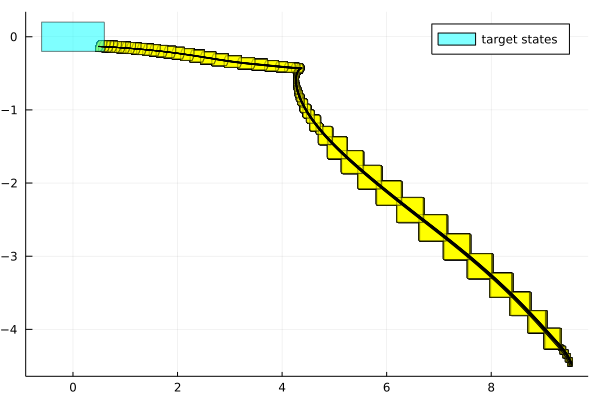

In [6]:
using Plots
import DisplayAs

solz = overapproximate(sol, Zonotope)
Tint = try convert(Int, T) catch; T end

function plot_helper(fig, vars; show_simulation::Bool=true)
    if vars[1] == 0
        target_set_projected = project(target_set, [vars[2]])
        time = Interval(0, T)
        target_set_projected = cartesian_product(time, target_set_projected)
    else
        target_set_projected = project(target_set, vars)
    end
    plot!(fig, solz, vars=vars, color=:yellow, lab="")
    plot!(fig, target_set_projected, color=:cyan, alpha=0.5, lab="target states")
    if show_simulation
        plot_simulation!(fig, sim; vars=vars, color=:black, lab="")
    end
end

vars = (1, 2)
fig = plot(xlab="x₁", ylab="x₂")
plot_helper(fig, vars)
# savefig("Unicycle-x1-x2.png")
fig = DisplayAs.Text(DisplayAs.PNG(fig))

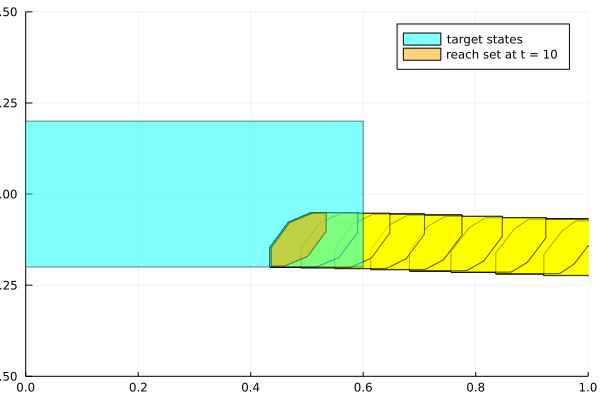

In [7]:
fig = plot(xlab="x₁", ylab="x₂")
plot_helper(fig, vars; show_simulation=false)
xlims!(0, 1)
ylims!(-0.5, 0.5)
plot!(fig, overapproximate(sol[end], Zonotope, tend(solz[end])), vars=vars,
      color=:orange, lab="reach set at t = $Tint")
# savefig("Unicycle-close-x1-x2.png")
fig = DisplayAs.Text(DisplayAs.PNG(fig))

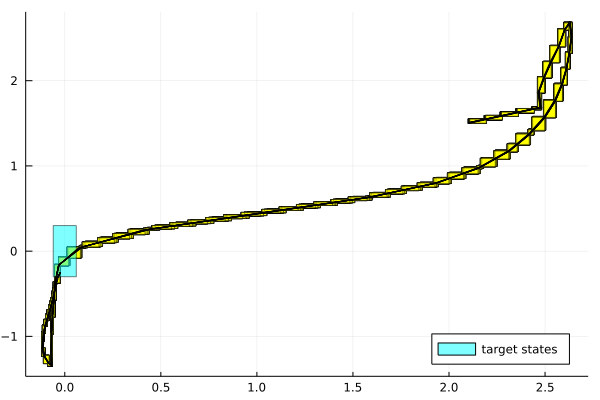

In [8]:
vars=(3, 4)
fig = plot(xlab="x₃", ylab="x₄", leg=:bottomright)
plot_helper(fig, vars)
# savefig("Unicycle-x3-x4.png")
fig = DisplayAs.Text(DisplayAs.PNG(fig))

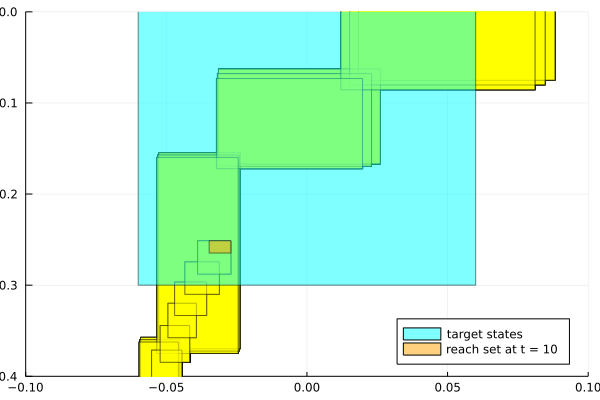

In [9]:
fig = plot(xlab="x₃", ylab="x₄", leg=:bottomright)
plot_helper(fig, vars; show_simulation=false)
xlims!(-0.1, 0.1)
ylims!(-0.4, 0)
plot!(fig, overapproximate(sol[end], Zonotope, tend(solz[end])), vars=vars,
      color=:orange, lab="reach set at t = $Tint")
# savefig("Unicycle-close-x3-x4.png")
fig = DisplayAs.Text(DisplayAs.PNG(fig))

## References

[^1] Souradeep Dutta, Xin Chen, and Sriram Sankaranarayanan. *Reachability
analysis for neural feedback systems using regressive polynomial rule
inference.* In [Proceedings of the 22nd ACMInternational Conference on Hybrid
Systems: Computation and Control, HSCC 2019, Montreal,QC, Canada,
April 16-18, 2019., pages 157–168, 2019](https://dl.acm.org/doi/abs/10.1145/3302504.3311807).